<a href="https://colab.research.google.com/github/HarrisonWBlack/Machine-Learning-CAP-5610/blob/master/Assignment%203/HW3_part1234.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1

In [308]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-17 23:36:41--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 2a00:1450:4013:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  68.5MB/s    in 1.0s    

2019-04-17 23:36:42 (68.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


train_dogs_dir = os.path.join(train_dir, 'dogs')
train_cats_dir = os.path.join(train_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')

In [0]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))


In [312]:
from keras import layers
from keras import models
from keras import optimizers

layer = conv_base.output
layer = layers.Flatten()(layer)
layer = layers.Dense(256, activation='relu')(layer)
layer = layers.Dropout(0.4)(layer)
layer = layers.Dense(1, activation='sigmoid')(layer)
model = models.Model(inputs=[conv_base.input], outputs=[layer])

for idx,layer in enumerate(model.layers):
    layer.trainable = idx >= 22

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [313]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(lr=2e-5), 
    metrics=['acc'])

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
    
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

path="./my_model.h5"
cp = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)
stop_early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, patience=10)
callbacks = [cp, stop_early]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callbacks
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/15
100/100 [==============================] - 22s 223ms/step - loss: 0.6905 - acc: 0.5925 - val_loss: 0.5215 - val_acc: 0.7860

Epoch 00001: val_acc improved from -inf to 0.78600, saving model to ./my_model.h5
Epoch 2/15
100/100 [==============================] - 17s 173ms/step - loss: 0.5891 - acc: 0.6820 - val_loss: 0.4504 - val_acc: 0.8010

Epoch 00002: val_acc improved from 0.78600 to 0.80100, saving model to ./my_model.h5
Epoch 3/15
100/100 [==============================] - 17s 170ms/step - loss: 0.5301 - acc: 0.7390 - val_loss: 0.4074 - val_acc: 0.8240

Epoch 00003: val_acc improved from 0.80100 to 0.82400, saving model to ./my_model.h5
Epoch 4/15
100/100 [==============================] - 17s 171ms/step - loss: 0.4863 - acc: 0.7605 - val_loss: 0.3791 - val_acc: 0.8280

Epoch 00004: val_acc improved from 0.82400 to 0.82800, saving model to ./my_model.h5
Epoch 5/15
100/100 [===============

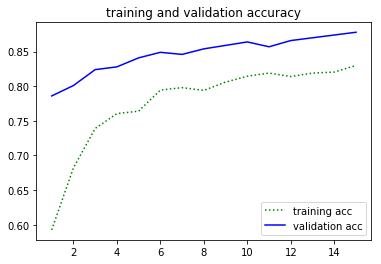

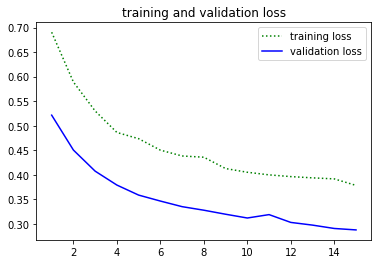

Validation loss: 0.2883672371506691
Validation accuracy: 0.8789999997615814


In [314]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='training acc', linestyle=":")
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='training loss', linestyle=":")
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Problem 2

In [315]:
model.load_weights("my_model.h5")
for idx,layer in enumerate(model.layers):
    layer.trainable = idx >= 20
    
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(lr=2e-5), 
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [316]:
path="./my_model_tuned.h5"
cp = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)
stop_early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, patience=20)
callbacks = [cp, stop_early]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callbacks
)

Epoch 1/15
100/100 [==============================] - 23s 229ms/step - loss: 0.3836 - acc: 0.8250 - val_loss: 0.2919 - val_acc: 0.8660

Epoch 00001: val_acc improved from -inf to 0.86600, saving model to ./my_model_tuned.h5
Epoch 2/15
100/100 [==============================] - 17s 173ms/step - loss: 0.3563 - acc: 0.8420 - val_loss: 0.2752 - val_acc: 0.8860

Epoch 00002: val_acc improved from 0.86600 to 0.88600, saving model to ./my_model_tuned.h5
Epoch 3/15
100/100 [==============================] - 17s 173ms/step - loss: 0.3496 - acc: 0.8425 - val_loss: 0.2704 - val_acc: 0.8760

Epoch 00003: val_acc did not improve from 0.88600
Epoch 4/15
100/100 [==============================] - 19s 187ms/step - loss: 0.3493 - acc: 0.8360 - val_loss: 0.2799 - val_acc: 0.8790

Epoch 00004: val_acc did not improve from 0.88600
Epoch 5/15
100/100 [==============================] - 17s 173ms/step - loss: 0.3107 - acc: 0.8615 - val_loss: 0.2366 - val_acc: 0.8960

Epoch 00005: val_acc improved from 0.8860

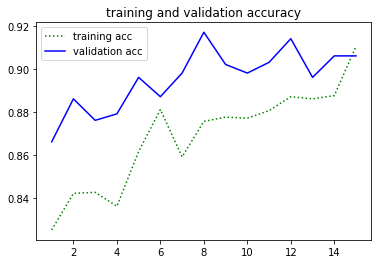

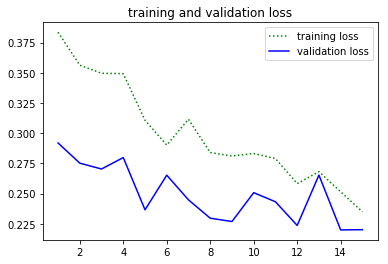

Validation loss: 0.22950780741870402
Validation accuracy: 0.9089999914169311


In [317]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='training acc', linestyle=":")
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='training loss', linestyle=":")
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Part Three

In [0]:
from keras.applications.vgg19 import VGG19 
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions

In [319]:
!wget https://cdn1.medicalnewstoday.com/content/images/articles/322/322868/golden-retriever-puppy.jpg?raw=true \
  -O dog1.jpg
  
!wget https://static-cdn.jtvnw.net/jtv_user_pictures/dogdog-profile_image-5550ade194780dfc-300x300.jpeg?raw=true \
  -O dog2.jpeg
  
!wget https://hips.hearstapps.com/ghk.h-cdn.co/assets/18/01/1515005599-miniature-pinscher.jpg?raw=true \
  -O dog3.jpg
  
!wget https://www.catster.com/wp-content/uploads/2018/07/Savannah-cat-long-body-shot.jpg?raw=true \
  -O cat1.jpg  
  
!wget https://ichef.bbci.co.uk/images/ic/720x405/p0517py6.jpg?raw=true \
  -O cat2.jpg  

!wget https://peopledotcom.files.wordpress.com/2018/04/zappa-the-cat-4.jpg?raw=true \
  -O cat3.jpg

--2019-04-17 23:46:17--  https://cdn1.medicalnewstoday.com/content/images/articles/322/322868/golden-retriever-puppy.jpg?raw=true
Resolving cdn1.medicalnewstoday.com (cdn1.medicalnewstoday.com)... 185.172.149.132, 2a0b:4d07:201::1
Connecting to cdn1.medicalnewstoday.com (cdn1.medicalnewstoday.com)|185.172.149.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41880 (41K) [image/jpeg]
Saving to: ‘dog1.jpg’

dog1.jpg            100%[===================>]  40.90K  --.-KB/s    in 0s      

2019-04-17 23:46:17 (435 MB/s) - ‘dog1.jpg’ saved [41880/41880]

--2019-04-17 23:46:19--  https://static-cdn.jtvnw.net/jtv_user_pictures/dogdog-profile_image-5550ade194780dfc-300x300.jpeg?raw=true
Resolving static-cdn.jtvnw.net (static-cdn.jtvnw.net)... 151.101.38.214
Connecting to static-cdn.jtvnw.net (static-cdn.jtvnw.net)|151.101.38.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30264 (30K) [image/jpeg]
Saving to: ‘dog2.jpeg’

dog2.jpeg        

In [0]:
img_path1 = 'dog1.jpg'
img_path2 = 'dog2.jpeg'
img_path3 = 'dog3.jpg'
img_path4 = 'cat1.jpg'
img_path5 = 'cat2.jpg'
img_path6 = 'cat3.jpg'

In [0]:
last_conv_layer = model.get_layer('block5_conv4')

In [0]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K

In [0]:
def show_superimposed_image(img_path, heatmap):
  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  cv2_imshow(superimposed_img)

In [0]:
def process_image(img_path, idx=0):
  img = image.load_img(img_path, target_size=(150, 150))
  plt.imshow(img)
  plt.grid(None)
  plt.show()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  
  class_index = np.argsort(preds[0])[-(1+idx)]
  class_output = model.output[:, class_index]
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0], model.output[0]])
  pooled_grads_value, conv_layer_output_value, prediction_percent = iterate([x])

  heatmap = np.mean(conv_layer_output_value, axis=-1) 
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  show_superimposed_image(img_path, heatmap)

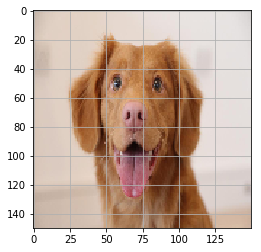

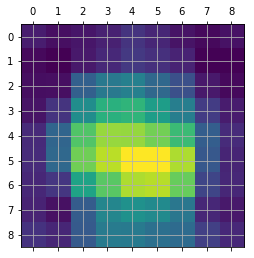

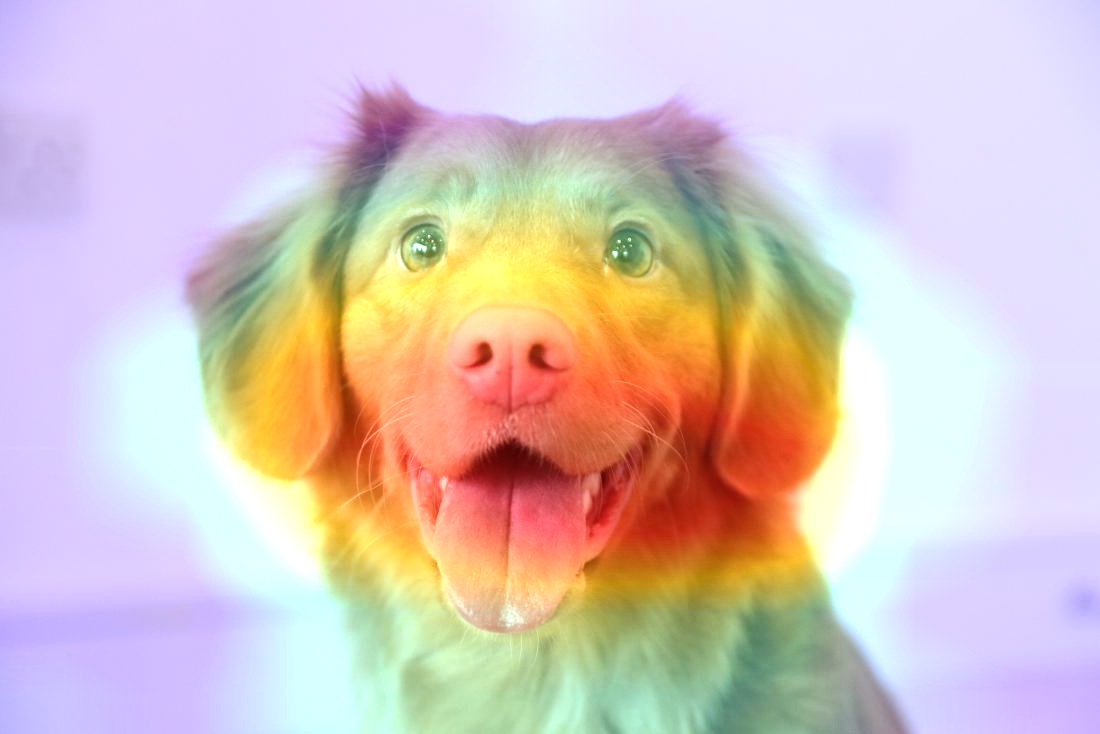

In [361]:
process_image(img_path1)

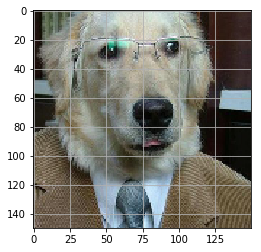

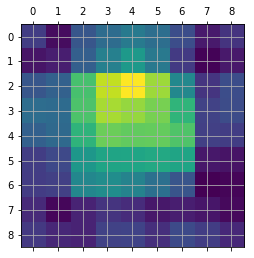

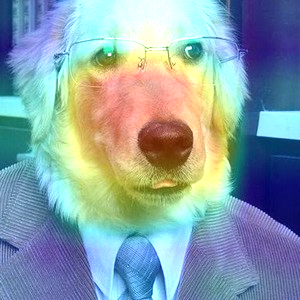

In [362]:
process_image(img_path2)

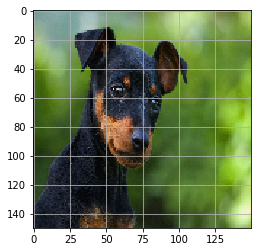

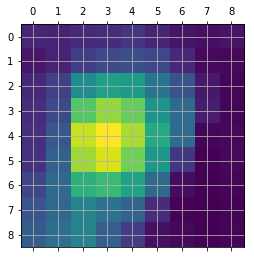

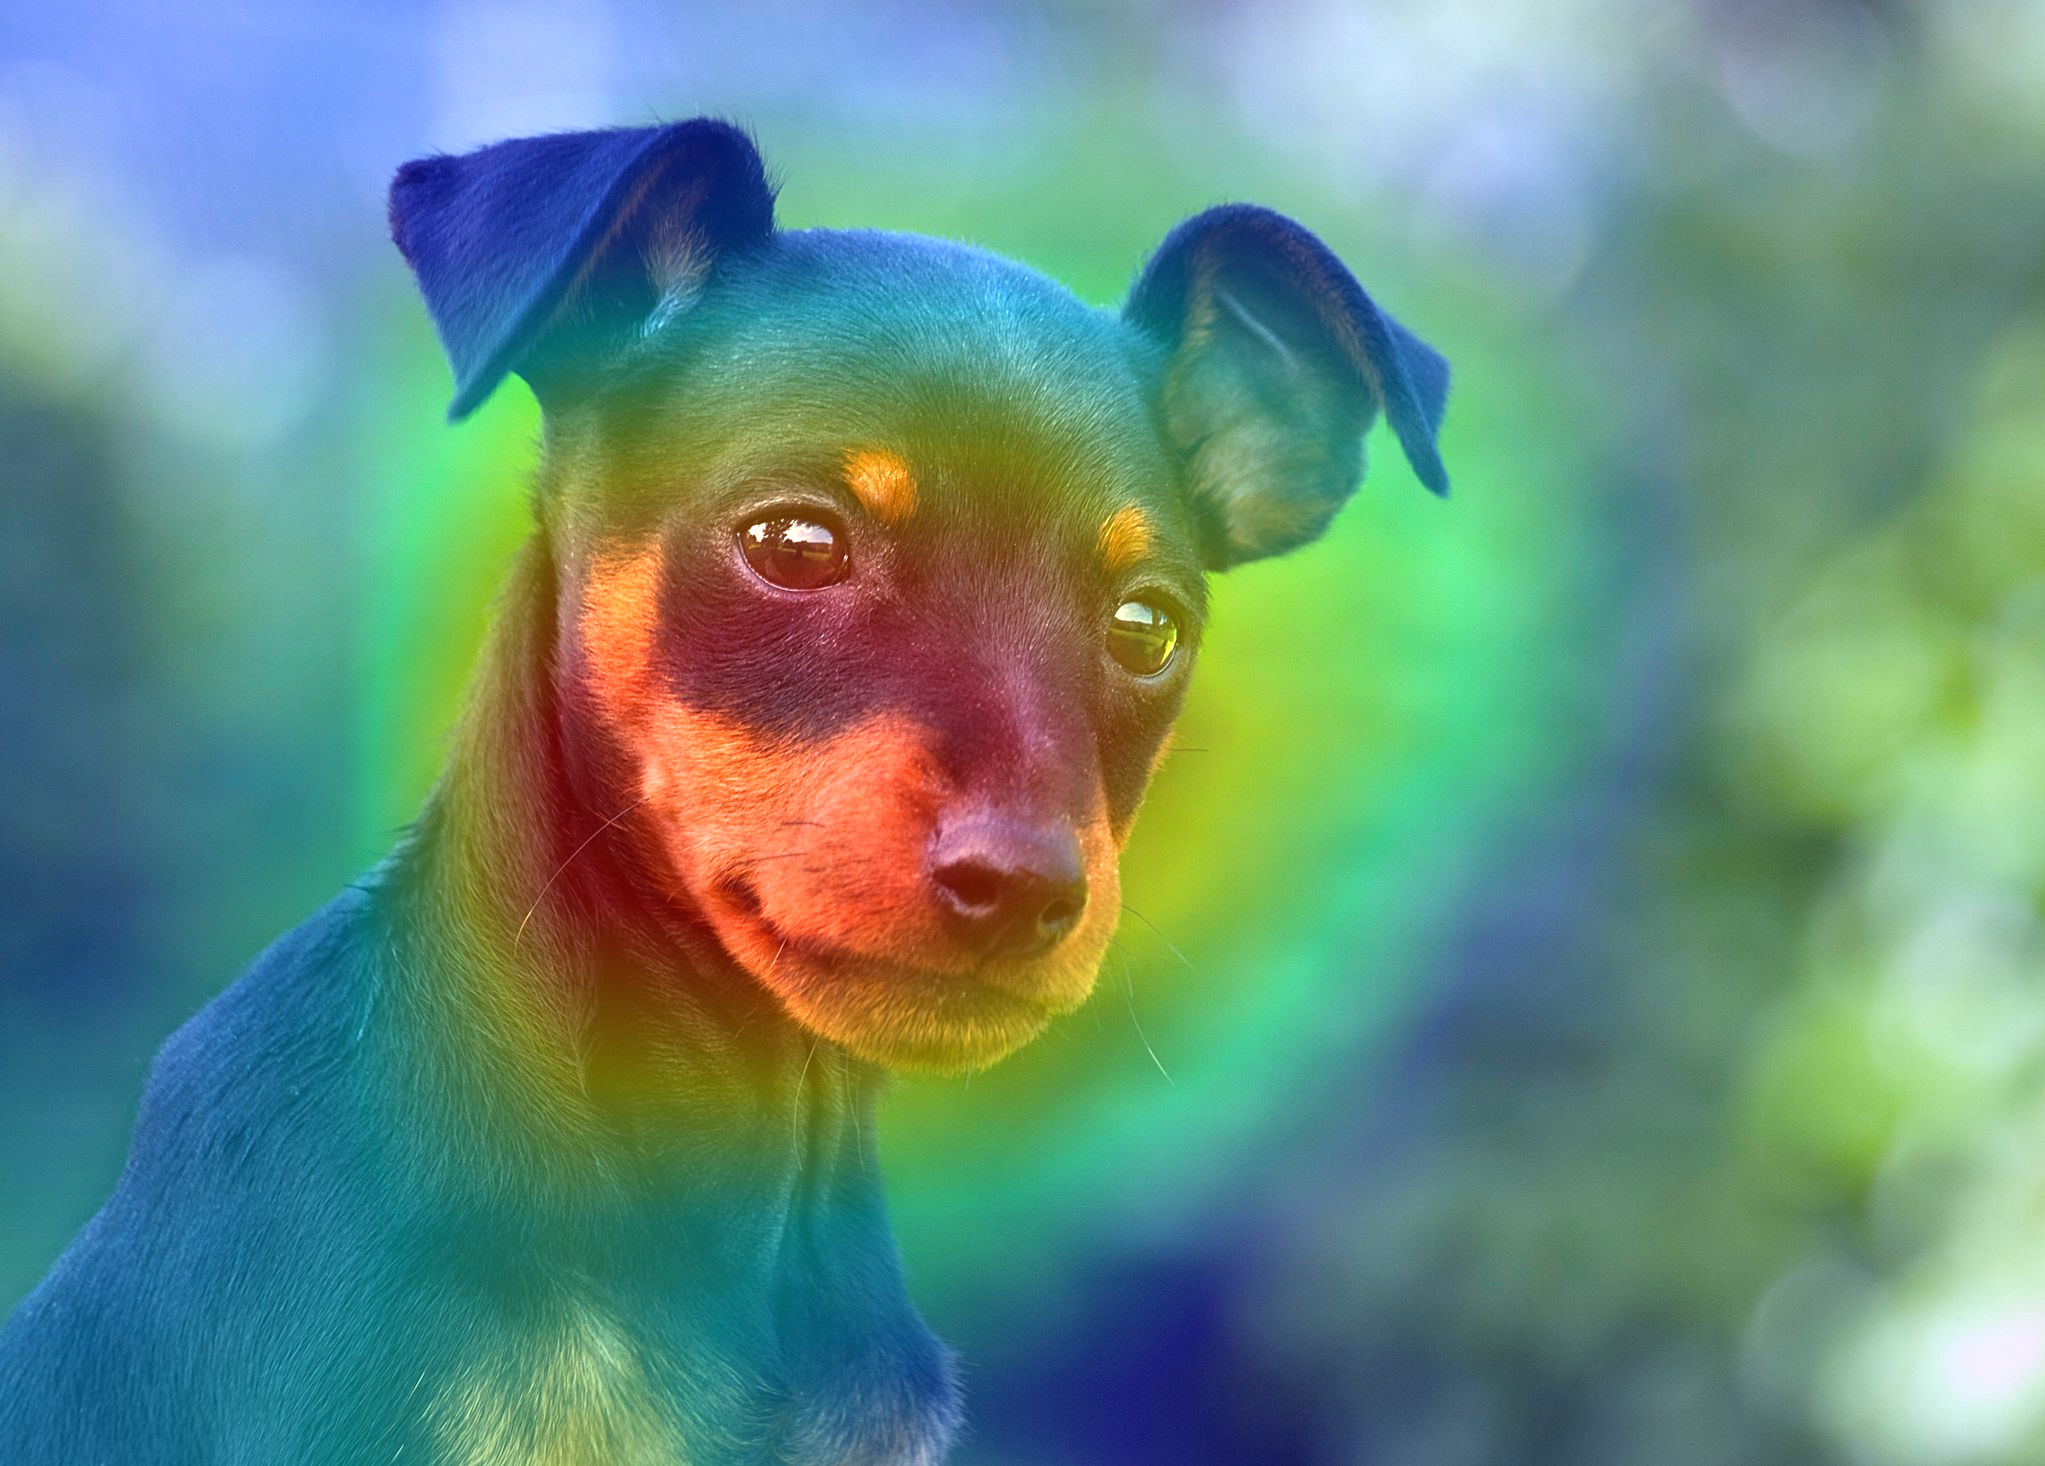

In [363]:
process_image(img_path3)

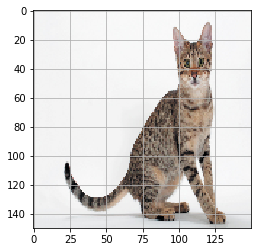

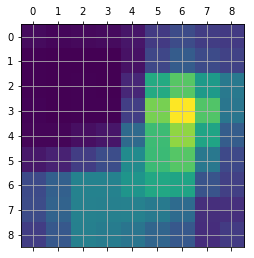

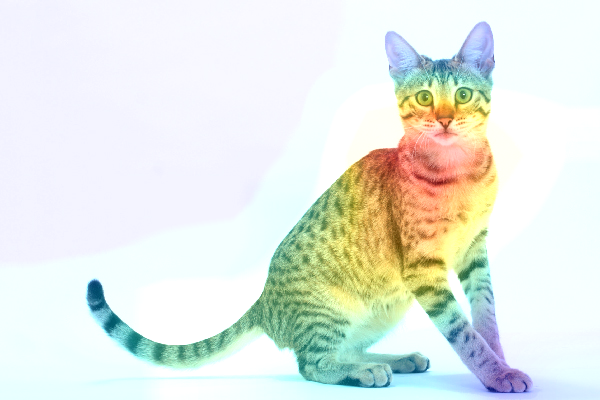

In [364]:
process_image(img_path4)

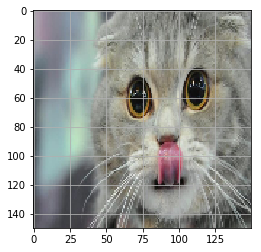

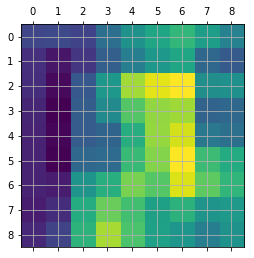

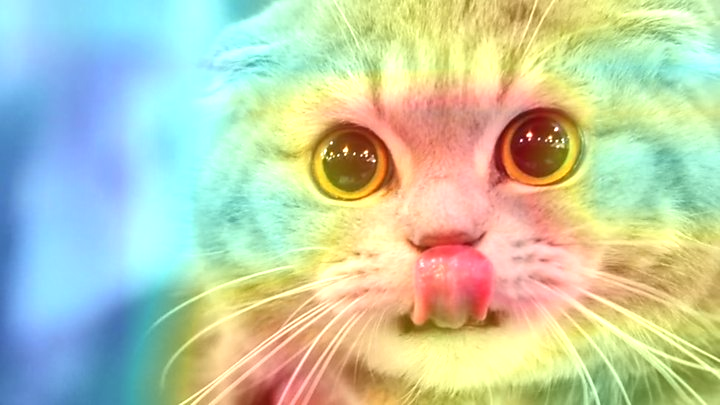

In [365]:
process_image(img_path5)

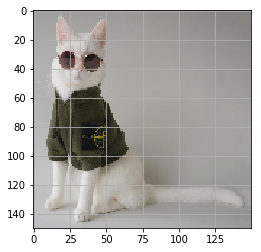

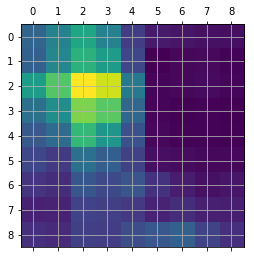

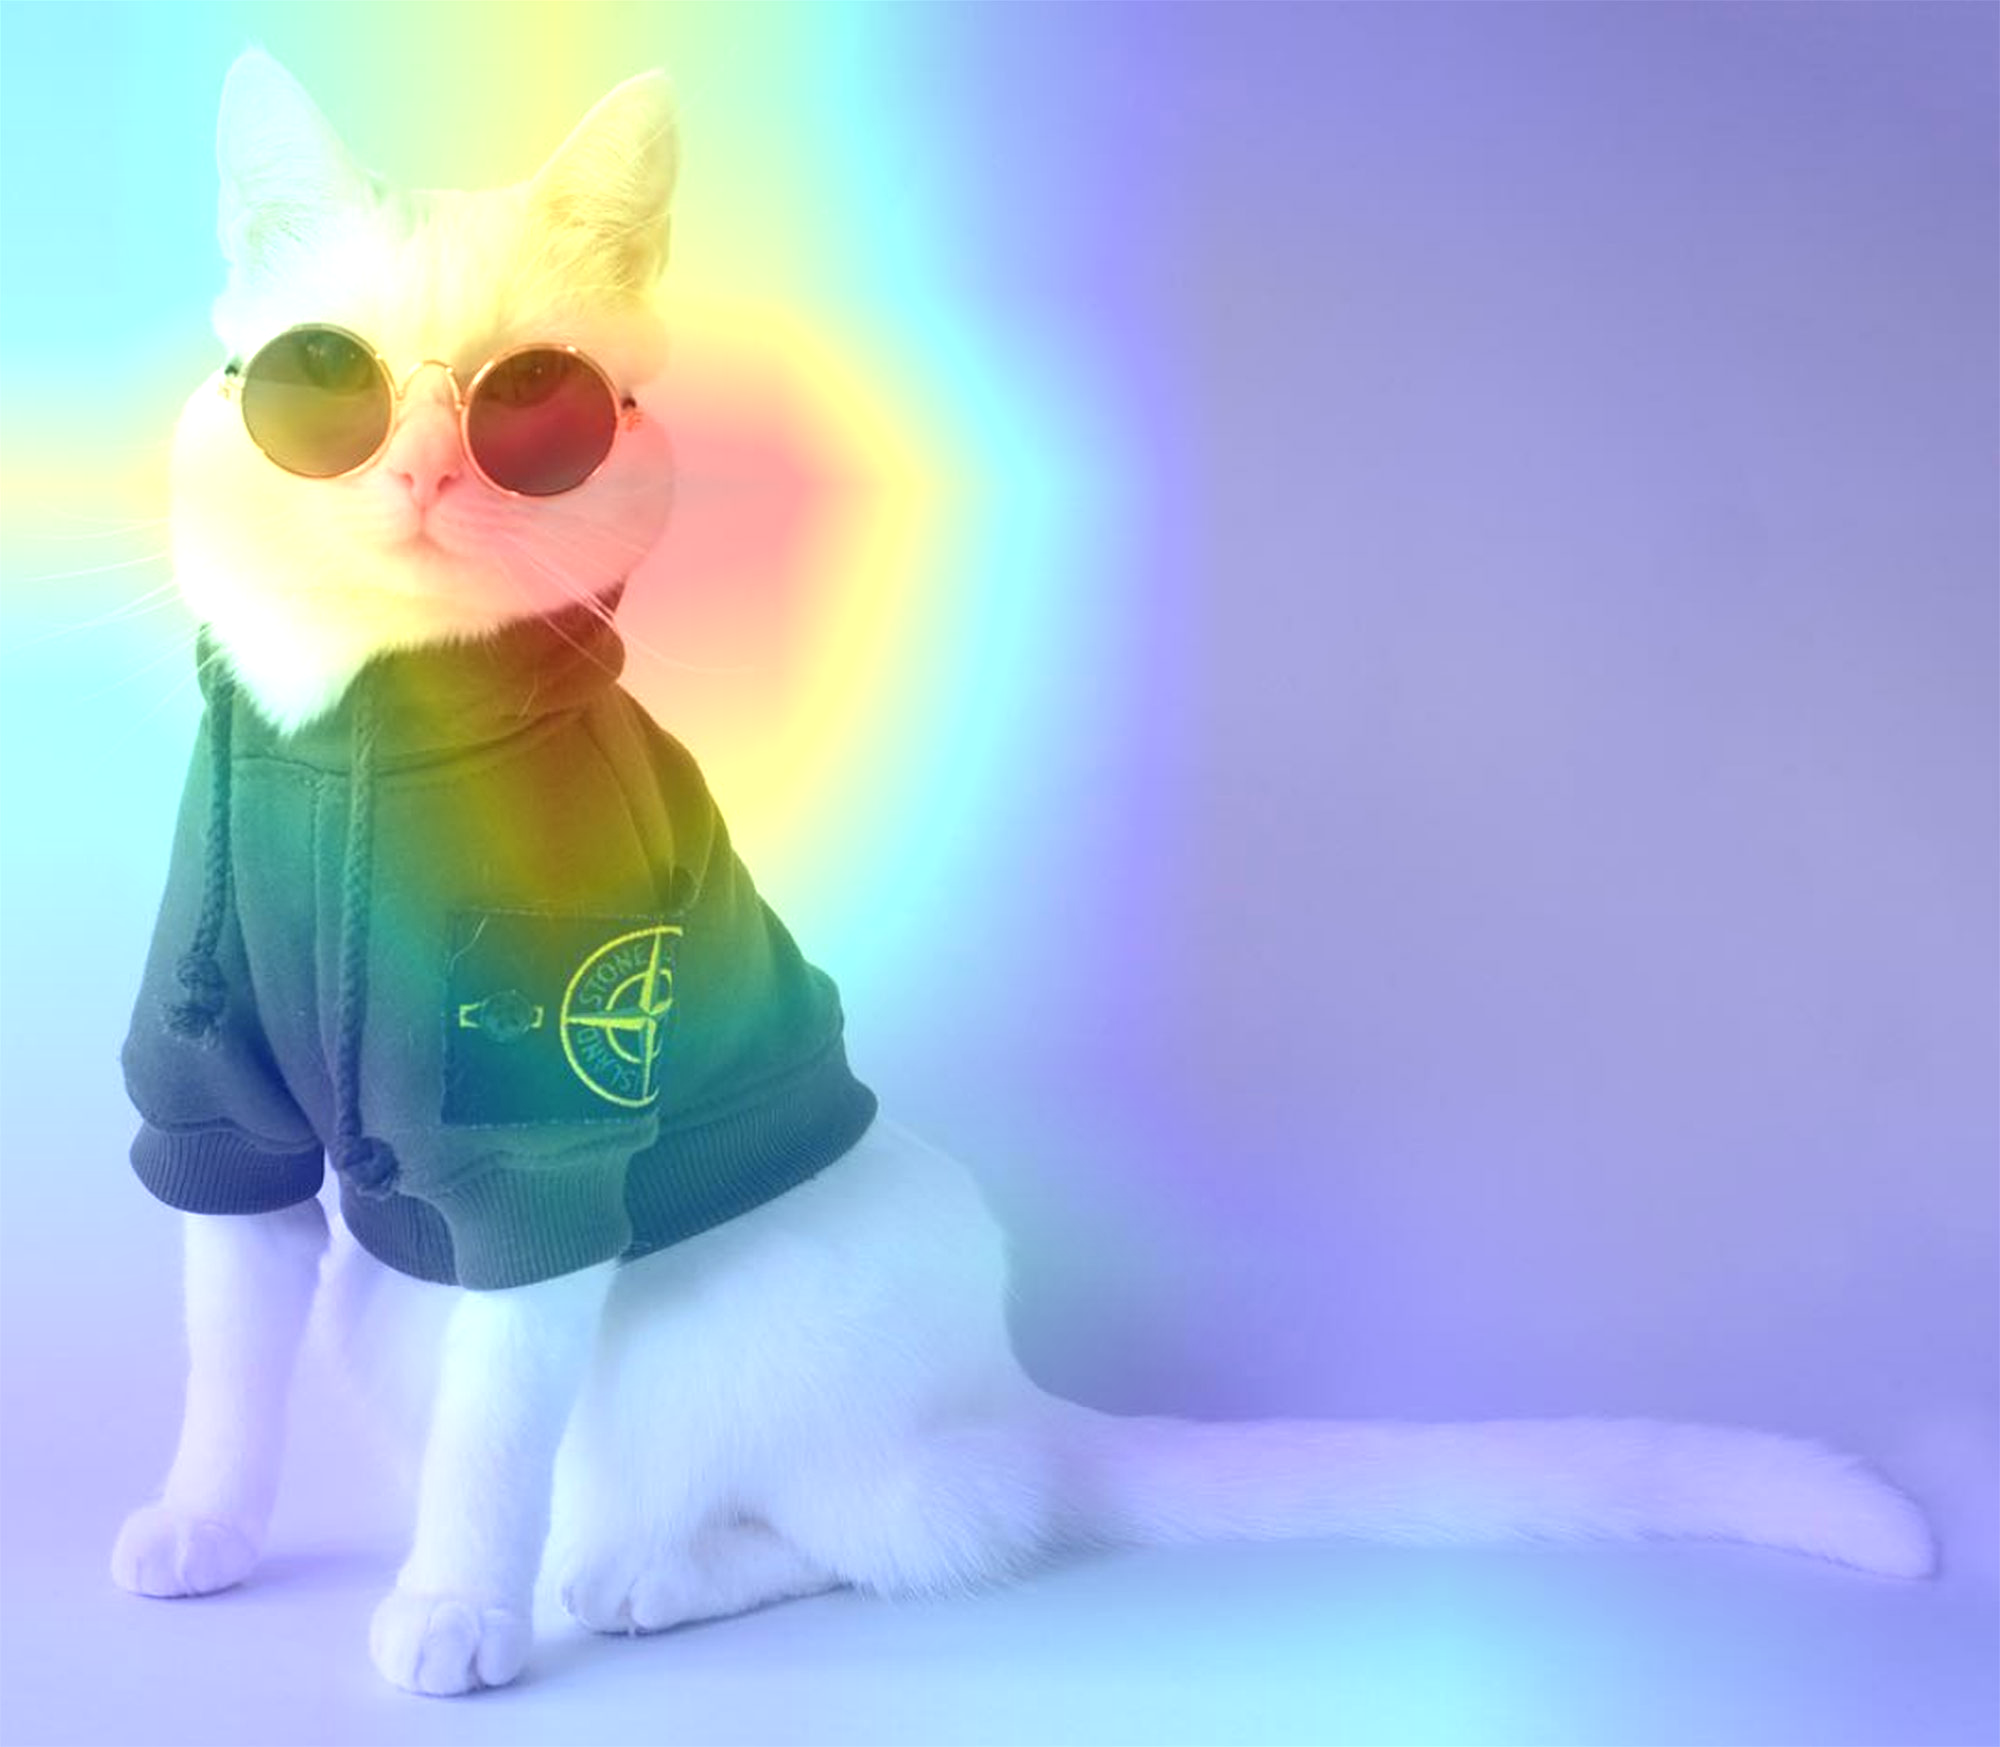

In [366]:
process_image(img_path6)